# PPO :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
import random

from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

#from utils.rnn import *
import model

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE

N_HISTORY = 1#4#
N_ACTORS = 1

DEVICE = "cpu"

In [3]:
from tasks.uml_reacher_moving_hrl import StaticReacherProxy, f_reward, N_REWARDS
from utils.task import Task

task = StaticReacherProxy()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Setup dummies ( unused feats in this environment )

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Set model wrappers

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

In [7]:
from utils.her import HER, CreditAssignment

from utils.gahil import GAHIL
GAN_REWARD = GAHIL(action_size=3)

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step, n_so, a) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps, states_1, actions)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            do_her = False
            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                    do_her = True
                delta += 1

            if 1 == len(rewards[i]):
                #assert False
                if do_her: GAN_REWARD.register_target(#old design to work over numpy
                    s.view(1, -1).numpy(), n_so.view(1, -1).numpy(), g.view(1, -1).numpy(), a.view(1, -1).numpy())
            else:
                her = torch.tensor(f_reward(s, n, g, None, True, None, None))
                h_rewards[i] = her if 9 == len(rewards[i]) else (0. if (her.mean() > 0.) else -.1)#her[6:]
#                h_rewards[i] = her[:6] if 6 == len(rewards[i]) else (0. if (her.mean() > 0.) else -1.)#her[6:]

            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
                
        if 1 == len(rewards[0]):
            return ( GAN_REWARD.register_other_with_reward(#old design to work over numpy
                states.numpy(), states_1.numpy(), h_goals.numpy(), actions.numpy()), 
                    h_goals, states, h_n_goals, n_states )

        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(gae, n_step, floating_step, gamma, gae_tau, her_delay):
    return CreditAssignment(gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 5. Setup && run agent/bot

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, 
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=2e-4, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=3,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

In [9]:
class HRL:
    def __init__(self, task, env, task_wrapper, recalc_reward, max_step, leaf_level, reset_level):
        self.task = task
        self.recalc_reward = recalc_reward

        self.env = env
        self.task_wrapper = task_wrapper
        self.leaf_level = leaf_level
        self.reset_level = reset_level
        self.steps = 0
        
        self.max_step=max_step
        
        # debug
        self.counter = 0

    def reset(self, agent, seed, learn_mode):
        #if self.reset_level: print("RESET", self.leaf_level, self.reset_level)
        self.steps = 0
        self.learn_mode = learn_mode
        if not self.reset_level:
            return self.task.info
        return self.task.reset(agent, seed, learn_mode)
    
    def step(self, actions):
        #if self.reset_level: print("STEP", self.leaf_level, self.reset_level, self.steps)
        self.steps += 1
        self.counter += 1
        
        if self.leaf_level:
            einfo = self._final_step(actions)
        else:
            einfo = self._higher_step(actions[:, :actions.shape[1]//3])
                
        if self.reset_level and self.leaf_level:# and not self.learn_mode:
            return einfo # one level, at eval we want full
        # for eval reasons ..
        if 0 == self.steps % self.max_step and 0. == einfo.dones[0]:
            einfo.dones = torch.ones_like(einfo.dones).double() * 2
            
        return einfo
    
    def _final_step(self, actions):
        einfo = self.task.step(actions)
        if self.reset_level and self.leaf_level:# and not self.learn_mode:
            return einfo # one level, at eval we want full
        
        # if we hit sooner target ok lets end it here!
        early_done = True
        for r in einfo.rewards:
            if r <= 0:#==.04
                early_done = False
                
        if early_done:
            #print("EARLY DONE!!", self.steps, einfo.rewards)
            einfo.dones = torch.ones_like(einfo.dones).double() * 2

#        einfo.custom_rewards = einfo.custom_rewards[:, :6]
        return einfo

    def _higher_step(self, actions):
# DEBUG
        for i, act in enumerate(actions):
            for j, a in enumerate(act):
                assert a == a
                
        itask = lambda: self.task_wrapper(self.task)
        if not self.learn_mode or random.randint(0, 1):
            task = Task(itask, np.inf, do_assess=False, goals=actions)
        else: # sometimes try with original goal, not suggested by higher level policy
            task = Task(itask, np.inf)#, norm=goal_encoder)
        
        if self.learn_mode:
            scores = self.env.step(task, 1) # perform 'hidden' n-step, dependent on actions==goals!!
            reward = self.recalc_reward(self.task.info) # actually here it does not matter at all, update_goal will do the job
            self.task.info.custom_rewards = reward
        else:
            _, reward = self.env.evaluate(task) # ok we want to debug original rewards function : 
            self.task.info.rewards = torch.tensor(np.mean(reward)).expand_as(self.task.info.rewards)

        einfo = self.task.info
        
        einfo.actions = actions # dont change -> then we may try to predict unreasonable goals over and over        
        if random.randint(0, 3):
            einfo.actions = self.task.stats[-random.randint(1, 9)][:, :3] # learn to output doable goals !!
            #einfo.actions = goal_encoder(einfo.actions)

        # early end by lower level, but not reset on full task, just at lower level
        if einfo.dones[0] == 2.: # eval, continue on higher level
            einfo.dones = torch.zeros_like(einfo.dones).double()

# DEBUG
        elif 0 == (self.counter % 50):
            print("ACTIONS -->", actions[0], self.task.goals[0], self.task.states[0, :3])        
        for eg, tg in zip(einfo.goals, self.task.goals):
            for e, g in zip(eg, tg):
                assert e == g
            
        return einfo

In [10]:
max_steps=30
BS = 2048
ppo_brain = [
    BrainDescription( # master :: PPO
        memory_size=20 * max_steps * 6, batch_size=BS, 
        optim_pool_size=(max_steps * 80 * 20) // 3,
        optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
        lr_actor=1e-4, learning_delay=1*max_steps, learning_repeat=20,
        sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1e-1,
        bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),
]
print("\nPPO: \n", [b for b in ppo_brain])

GAHIL_MAX_STEPS = 4
PPOBS = 1024
gahil_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * 100 * 3, batch_size=PPOBS, 
            
            optim_pool_size=(20 * 40 * 3) // 3,
            optim_epochs=1, optim_batch_size=1*PPOBS,  recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=10, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1e-1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
print("\nGAHIL: \n", [b for b in gahil_brain])


PPO: 
 [[3600, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 16000, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 30, '<- learning_delay;', 20, '<- learning_repeat;', 0.0001, '<- lr_actor;', 1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]

GAHIL: 
 [[6000, '<- memory_size;', 1024, '<- batch_size;', 1, '<- optim_epochs;', 1024, '<- optim_batch_size;', 800, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 20, '<- learning_repeat;', 0.0001, '<- lr_actor;', 1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]


In [11]:
def reward_rescale(info):
    return ((info.rewards > .0).double() - 1.) / 10.

def gahil_rescale(info):
    return torch.zeros(info.rewards.shape[0], 1) # does not matter will be recaulculated per ep in update_goal

proxy_wrap = lambda data: data

agent1, env1 = new_agent(
    [2], ppo_brain, 
    goal_encoder, encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=3, max_steps=30,
    detach_actors=False, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=False, load=False
    )

agent2, env2 = new_agent(
    #[1000000, 2], bnpo_brain, 
    [2], gahil_brain, 
    goal_encoder, encoder, freeze_delta=1, freeze_count=np.inf, 
    action_size=3, n_rewards=1, n_step=1, max_steps=GAHIL_MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=False, load=False
    )
TOP_MAX_STEPS=40
agent3, env3 = new_agent(
#    [0], ppo_brain, 
    [2], ppo_brain, 
    goal_encoder, encoder, freeze_delta=1, freeze_count=np.inf, 
    action_size=3, n_rewards=1, n_step=3, max_steps=TOP_MAX_STEPS,
    detach_actors=False, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=False, load=False
    )

level1 = lambda t: HRL(t, None, None, None, max_step=max_steps, leaf_level=True, reset_level=False)
executor, hrl, env = Task(lambda: level1(task), 30.), level1, env1

level2 = lambda t: HRL(t, env1, level1, gahil_rescale, max_step=GAHIL_MAX_STEPS, leaf_level=False, reset_level=False)
executor, hrl, env = Task(lambda: level2(task), 30.), level2, env2

#level3 = lambda t: HRL(t, env, hrl, gahil_rescale, max_step=TOP_MAX_STEPS, leaf_level=False, reset_level=True)
level3 = lambda t: HRL(t, env, hrl, reward_rescale, max_step=TOP_MAX_STEPS, leaf_level=False, reset_level=True)
executor, hrl, env = Task(lambda: level3(task), 30.), level3, env3

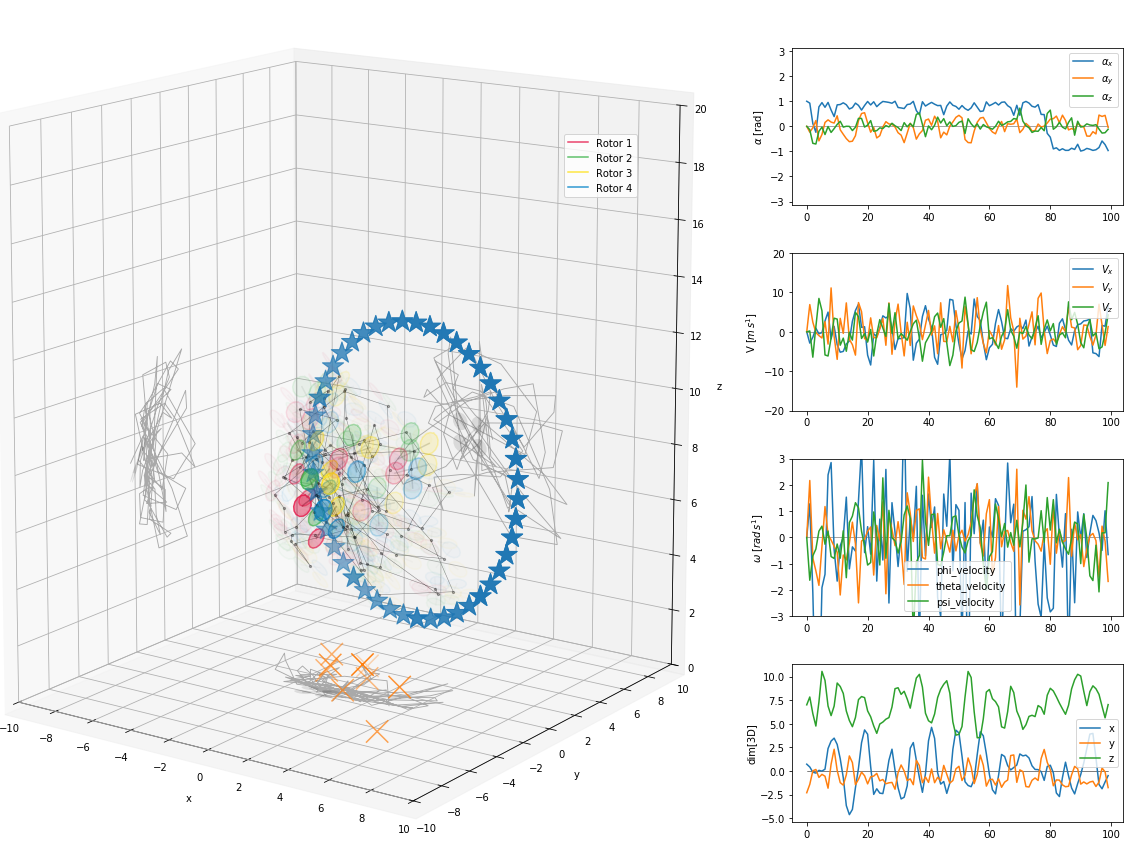

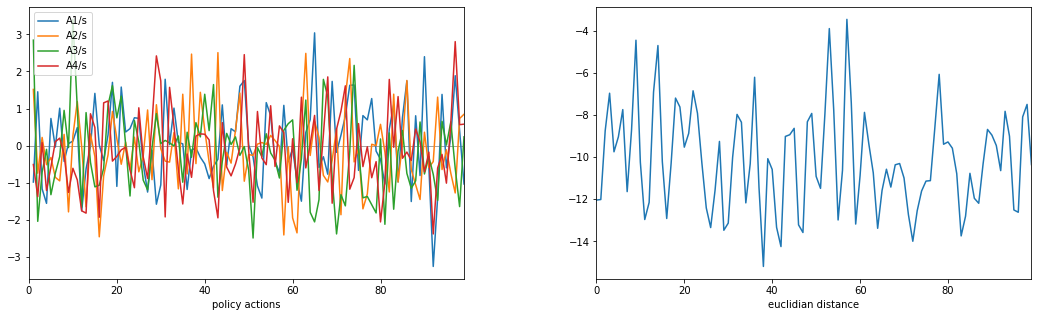

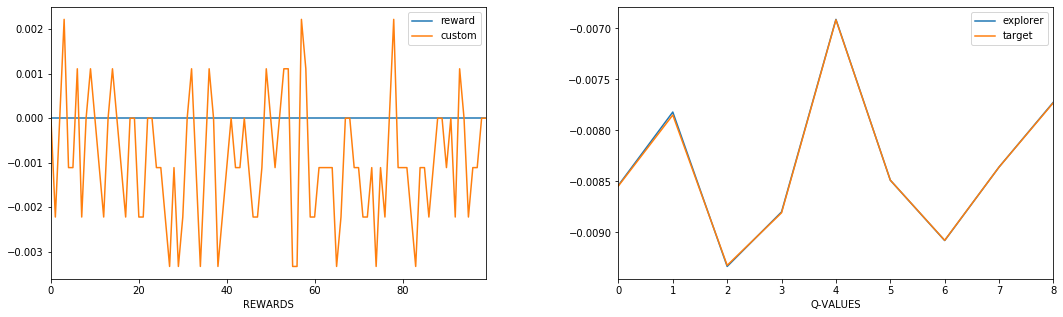

[   37>  1079:: 0] steps =   13, max_step =  30/ 16, reward=-0.010778 <action=tensor([-1.5506,  0.1648,  0.6719,  1.1225])>                                    PPO too off, from sampled actions, policies problems!!  20 612 tensor(-5.4733, grad_fn=<MeanBackward0>) tensor(-1.4005)
[   38>  1109:: 0] steps =   13, max_step =  30/ 16, reward=-0.006944 <action=tensor([-0.8848,  5.8034,  0.3805,  2.2316])>                    PPO too off, from sampled actions, policies problems!!  40 612 tensor(-4.0911, grad_fn=<MeanBackward0>) tensor(-1.4024)
[   42>  1229:: 0] steps =   13, max_step =  30/ 16, reward=-0.009889 <action=tensor([-0.3896,  5.3971, -0.2219,  0.5973])>                                    PPO too off, from sampled actions, policies problems!!  60 678 tensor(-5.1078, grad_fn=<MeanBackward0>) tensor(-1.4065)
[    2>    25:: 0] steps =   12, max_step =  13/ 13, reward=-1.085000 <action=tensor([ 7.3487, -0.0285,  2.6925])>                                             
	 [ 2 ] < 958.76 se

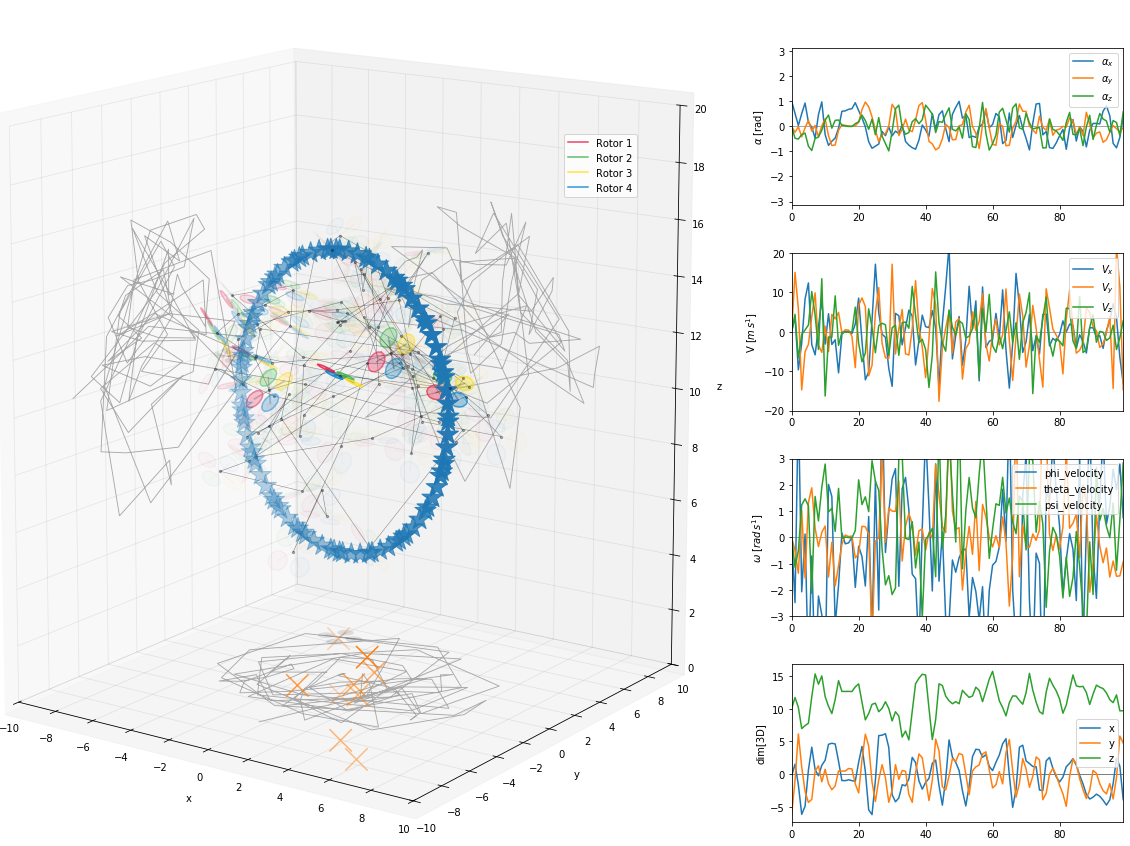

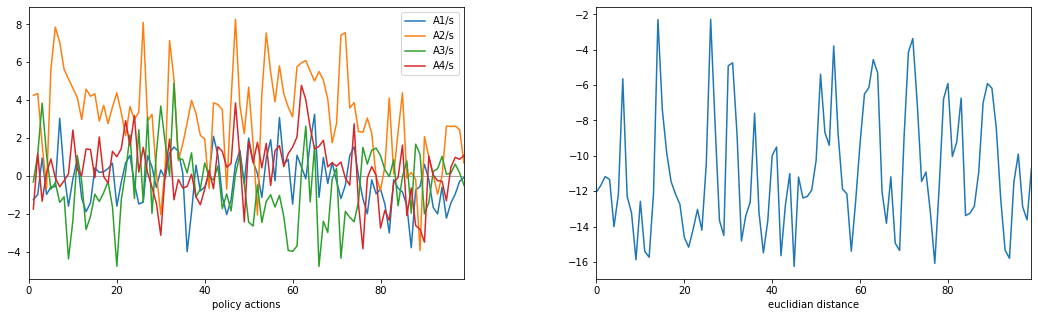

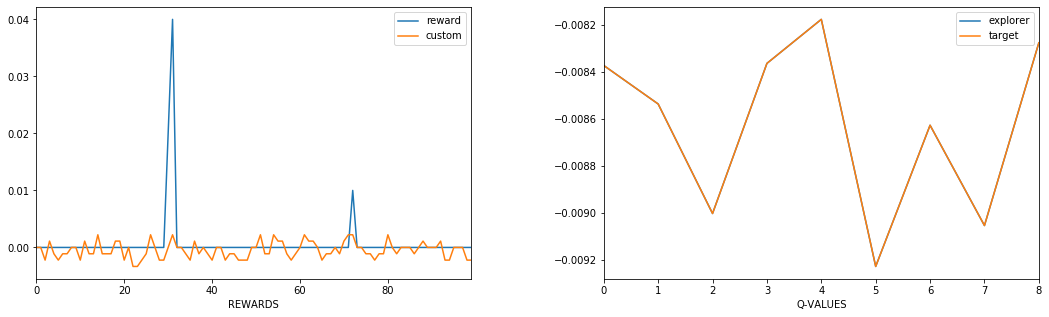

[   32>   125:: 0] steps =    3, max_step =   4/  3, reward=0.000000 <action=tensor([ 2.6561, -3.3798, -2.3806])>                    ACTIONS --> tensor([ 0.7337,  0.0395, -0.4315]) tensor([ 7.7793, -1.0000,  1.8662]) tensor([ 2.7005, -7.2943,  1.3861])
[  142>  4199:: 0] steps =   25, max_step =  30/ 16, reward=-0.018111 <action=tensor([ 3.3475,  6.7192, -4.1250,  3.9644])>                                    PPO too off, from sampled actions, policies problems!!  80 2635 tensor(-3.6936, grad_fn=<MeanBackward0>) tensor(-1.4761)
[    5>    64:: 0] steps =   12, max_step =  13/ 13, reward=-1.040000 <action=tensor([ 0.4323,  0.1148, -0.3666])>                                             
	 [ 5 ] < 2449.75 sec > TEST ==>  [[tensor(0.8435)]] exploring score: tensor(-1.1350)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   410.52ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   410.47ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   41

[   23>   298:: 0] steps =   12, max_step =  13/ 13, reward=-1.025000 <action=tensor([-3.8568, -4.4711,  1.1239])>                                             
	 [ 23 ] < 12133.31 sec > TEST ==>  [[tensor(1.3035)]] exploring score: tensor(-1.1200)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   433.93ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   433.88ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   433.86ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  76.9%   333.57ms/cyc @     0.2 calls/cyc
            _push_to_fast:  59.0%   256.16ms/cyc @    87.9 calls/cyc
                   _learn:  30.2%   130.87ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  23.1%   100.24ms/cyc @     0.4 calls/cyc
                 backprop:  14.8%    64.16ms/cyc @     1.3 calls/cyc
                 __call__:  12.2%    52.92ms/cyc @    88.7 calls/cyc
                    _push:   7.3%    31.77ms/cyc @     0.9 calls/cyc
             reca

[  515>  2017:: 0] steps =    3, max_step =   4/  3, reward=0.000000 <action=tensor([ 0.8852, -6.3332,  5.1387])>                    ACTIONS --> tensor([ 0.4279, -0.6056,  0.8952]) tensor([-4.2984, -1.0000,  6.7472]) tensor([ 0.9754, -4.4841,  3.6285])
[   44>   571:: 0] steps =   12, max_step =  13/ 13, reward=-0.990000 <action=tensor([-4.3210, -3.5857,  7.8618])>                                             
	 [ 44 ] < 23542.82 sec > TEST ==>  [[tensor(1.9205)]] exploring score: tensor(-1.0800)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   439.32ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   439.27ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   439.25ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  77.0%   338.31ms/cyc @     0.2 calls/cyc
            _push_to_fast:  59.2%   259.91ms/cyc @    88.6 calls/cyc
                   _learn:  29.9%   131.56ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  23.0%   100.

[  752>  2945:: 0] steps =    3, max_step =   4/  3, reward=0.000000 <action=tensor([-0.3911, -0.5183,  1.3077])>                    ACTIONS --> tensor([0.2508, 2.3137, 0.7037]) tensor([-1.6713, -1.0000, -7.8235]) tensor([ 2.5278, -4.5755, -5.0708])
[   65>   844:: 0] steps =   12, max_step =  13/ 13, reward=-0.965000 <action=tensor([ 1.7389, -0.4118, -1.3137])>                                            
	 [ 65 ] < 35162.90 sec > TEST ==>  [[tensor(1.1735)]] exploring score: tensor(-1.0550)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   444.11ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   444.06ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   444.04ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  77.3%   343.21ms/cyc @     0.2 calls/cyc
            _push_to_fast:  59.4%   263.81ms/cyc @    89.3 calls/cyc
                   _learn:  29.6%   131.64ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  22.7%   100.79ms

[   83>  1078:: 0] steps =   12, max_step =  13/ 13, reward=-0.865000 <action=tensor([-1.2989, -3.5686,  2.4387])>                                            
	 [ 83 ] < 45174.87 sec > TEST ==>  [[tensor(0.9810)]] exploring score: tensor(-0.9200)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   446.75ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   446.69ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   446.67ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  77.4%   345.78ms/cyc @     0.2 calls/cyc
            _push_to_fast:  59.5%   265.86ms/cyc @    89.6 calls/cyc
                   _learn:  29.5%   131.76ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  22.6%   100.85ms/cyc @     0.4 calls/cyc
                 backprop:  14.5%    64.57ms/cyc @     1.3 calls/cyc
                 __call__:  12.5%    55.64ms/cyc @    90.5 calls/cyc
                    _push:   7.7%    34.56ms/cyc @     0.9 calls/cyc
             recal

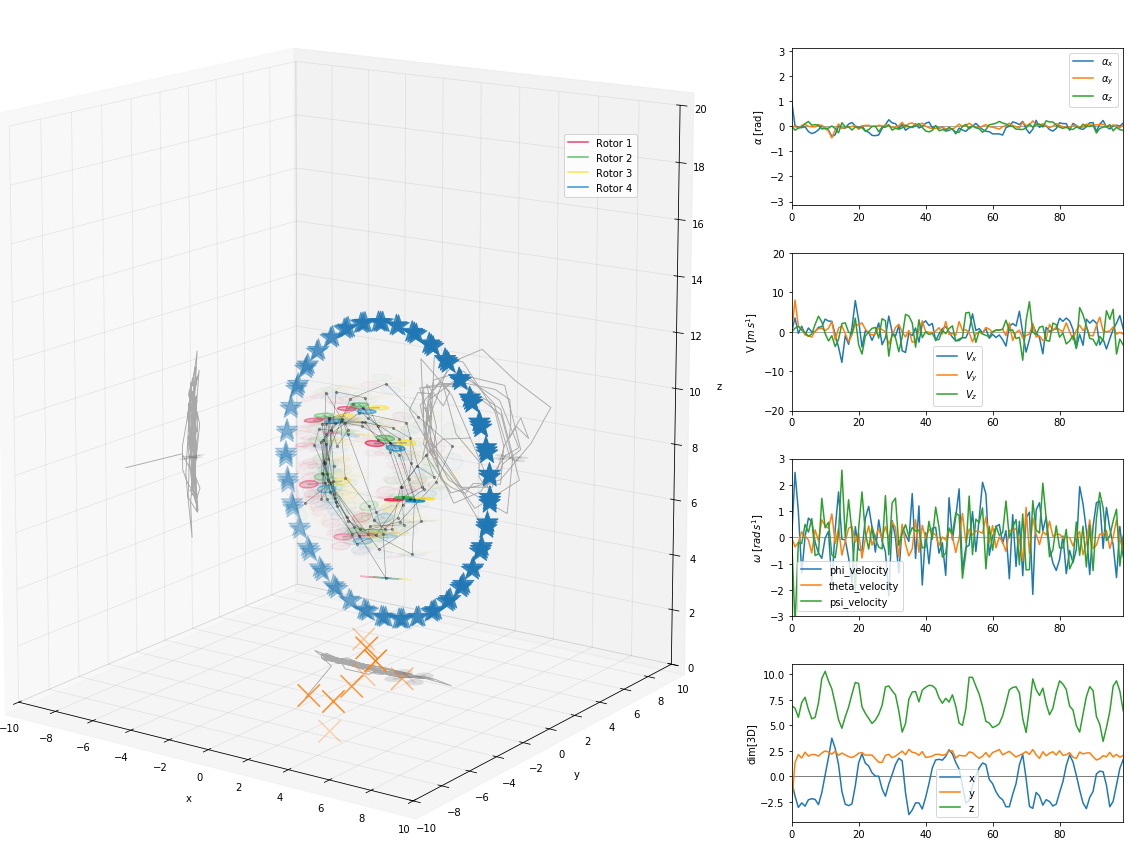

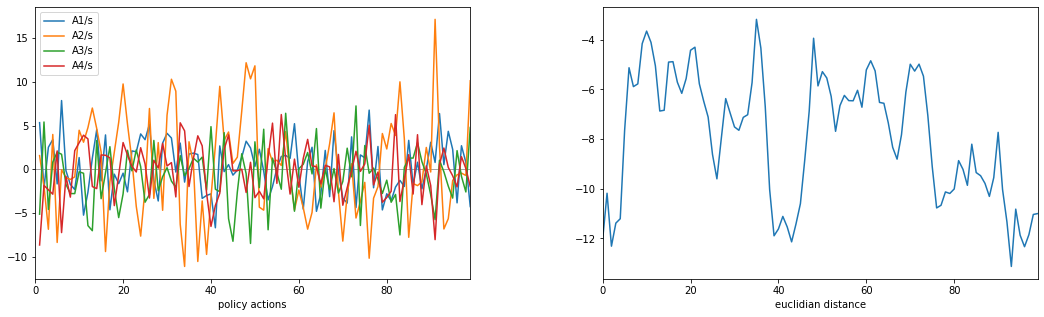

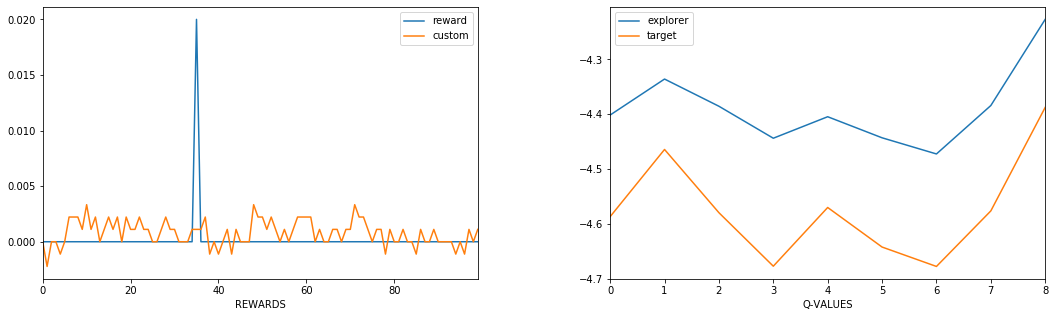

[ 1235>  4839:: 0] steps =    3, max_step =   4/  3, reward=0.000000 <action=tensor([-1.0264,  1.1871, -2.3438])>                    ACTIONS --> tensor([-0.7787,  0.9090, -0.8378]) tensor([-7.9764, -1.0000,  0.6136]) tensor([-6.3987, -2.8602, -0.2779])
[  104>  1364:: 0] steps =   12, max_step =  18/ 13, reward=-0.810000 <action=tensor([ 5.3608, -2.2029,  1.3202])>                                            
	 [ 104 ] < 56938.82 sec > TEST ==>  [[tensor(1.1085)]] exploring score: tensor(-0.8300)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   449.07ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   449.01ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   448.99ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  77.6%   348.33ms/cyc @     0.2 calls/cyc
            _push_to_fast:  59.7%   267.91ms/cyc @    90.1 calls/cyc
                   _learn:  29.3%   131.71ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  22.4%   100.

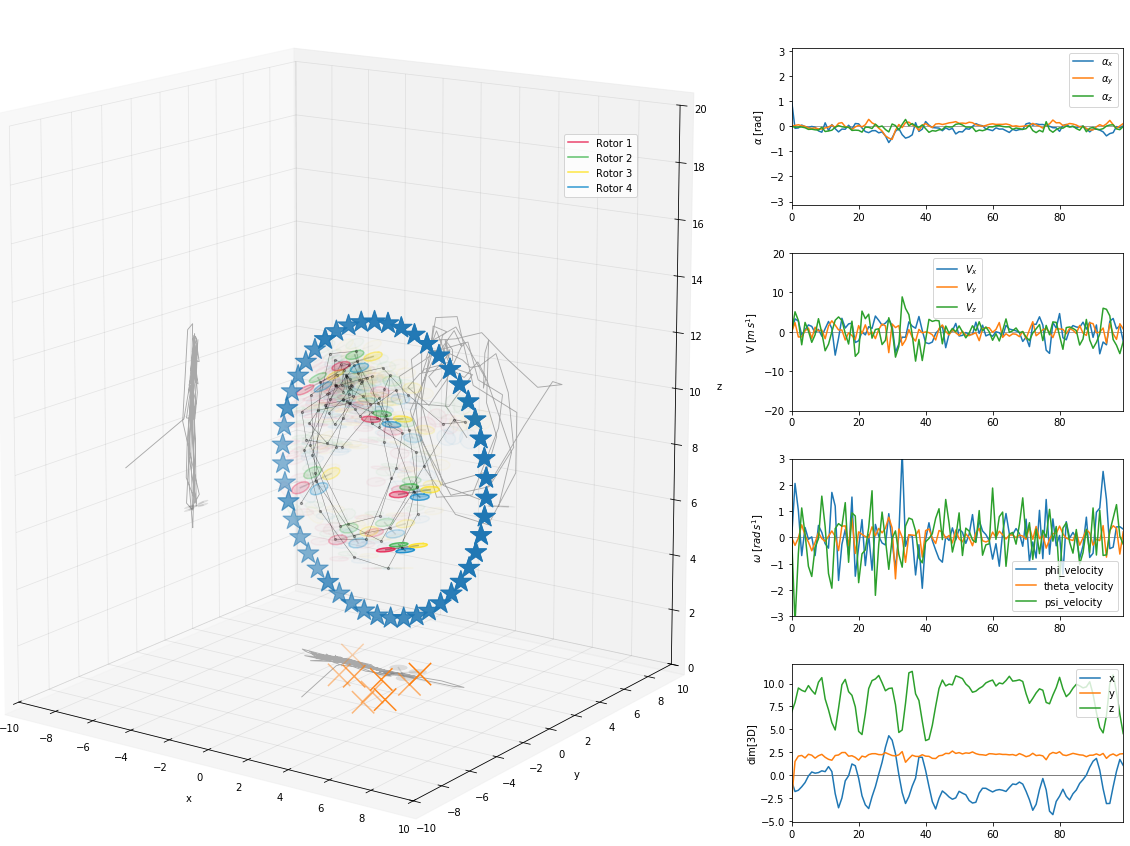

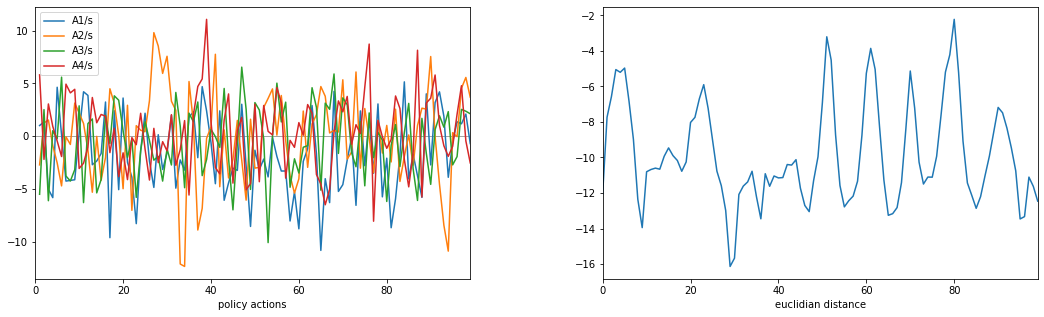

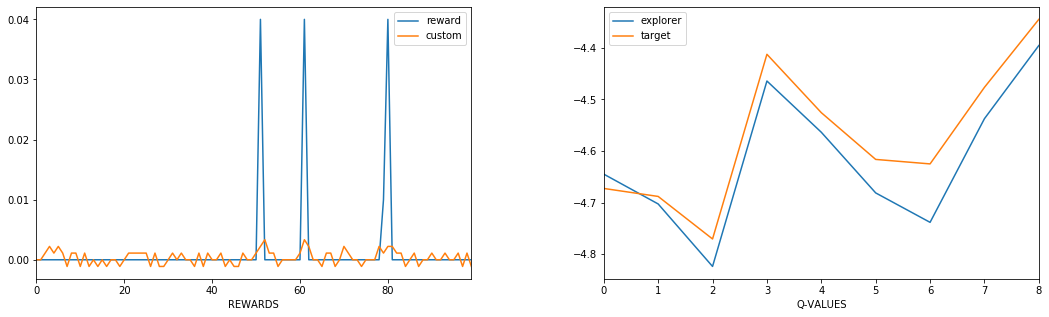

[ 1317>  5161:: 0] steps =    3, max_step =   4/  3, reward=0.000000 <action=tensor([-5.1744, -2.2997, -2.0283])>                    ACTIONS --> tensor([1.8127, 1.0820, 0.9058]) tensor([-7.3513, -1.0000, -3.1557]) tensor([-4.0001, -2.4129, -2.8155])
[ 1337>  5238:: 0] steps =    1, max_step =   4/  3, reward=0.000000 <action=tensor([ 1.5498, -2.5535,  4.9362])>                                             

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [12]:
scores = env.start(executor, callback)

In [ ]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 4. Plot reward + loss

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [ ]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 5. Test visuals - TARGET

In [ ]:
rewards = [[], []]
while len(rewards) < 100:
    success, scores = env.evaluate()
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER

In [ ]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards) < 100:
    success, scores = env.evaluate()
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()